In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))



%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (12, 8)
matplotlib.rcParams['font.size'] = 16

from collections import defaultdict
from scipy.interpolate import interpolate
import pandas as pd
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

In [2]:
def get_theta(x, y, r, phi, fl):
    dx_plane = np.sqrt((x - r * np.cos(phi))**2 + (y - r * np.sin(phi))**2)
    return np.arctan(dx_plane / fl)

def wavelength_shift(lam0, theta, ref_index):
    frac_shift = np.sqrt(1 - np.sin(theta)**2 * (1. / ref_index**2))
    return lam0 * (1 - frac_shift)

def transmission_chip(x0, y0, r_min, r_max, focal_length, filter_name='ha', bandpass='3nm', line_offset=0):
    phi_vals = np.linspace(0, 2 * np.pi, 50)
    r_vals = np.linspace(r_min, r_max, 50)

    R, PHI = np.meshgrid(r_vals, phi_vals)
    THETA = get_theta(x0[None, None, :, :], y0[None, None, :, :], R[:, :, None, None], PHI[:, :, None, None], focal_length)

    line_loc = bands[filter_name]['wavelength']
    func = f_transmission[f'{filter_name}_{bandpass}']

    lam = wavelength_shift(line_loc, THETA, n_index) + line_loc + line_offset
    
    d_transmission = func(lam)
    T = ((R[:, :, None, None] * d_transmission).sum(axis=0).sum(axis=0) / (d_transmission.max() * R[:, :, None, None]).sum(axis=0).sum(axis=0))
    return T, THETA

In [3]:
def transmission_chip(x0, y0, r_min, r_max, focal_length, filter_name='ha', bandpass='3nm', line_offset=None):
    phi_vals = np.linspace(0, 2 * np.pi, 50)
    r_vals = np.linspace(r_min, r_max, 50)

    R, PHI = np.meshgrid(r_vals, phi_vals)
    THETA = get_theta(x0[None, None, :, :], y0[None, None, :, :], R[:, :, None, None], PHI[:, :, None, None], focal_length)

    line_loc = bands[filter_name]['wavelength']
    func = f_transmission[f'{filter_name}_{bandpass}']

    lam = wavelength_shift(line_loc, THETA, n_index) + line_loc
    
    if line_offset:
        T = []
        n_samples = 100
        lam += line_offset
        for _ in range(n_samples):
            d_transmission = func(lam + line_offset * np.random.randn())
            T.append(((R[:, :, None, None] * d_transmission).sum(axis=0).sum(axis=0) / (d_transmission.max() * R[:, :, None, None]).sum(axis=0).sum(axis=0)))
    else:
        d_transmission = func(lam)
        T = ((R[:, :, None, None] * d_transmission).sum(axis=0).sum(axis=0) / (d_transmission.max() * R[:, :, None, None]).sum(axis=0).sum(axis=0))
    return T, THETA

In [4]:
def show_chip_view(optics, filter_names, bandpasses, downsample=200, frame_size=[36, 24], suffix=''):
    micron = 1e-3
    width, height = frame_size
    pixel_size = 3.76 * micron * downsample

    n_x = int(width / pixel_size)
    n_y = int(height / pixel_size)
    x = np.linspace(-width / 2, width / 2, n_x)
    y = np.linspace(-height / 2, height / 2, n_y)
    X, Y = np.meshgrid(x, y)

    n_panel = len(optics)
    thetas = defaultdict(dict)
    for filter_name in filter_names:
        for bandpass in bandpasses:
            plt.figure(figsize=(n_panel * 9, 6))
            for i_panel, (optic_name, specs) in enumerate(optics.items()):
                plt.subplot(1, n_panel, i_panel + 1)
                aperture = specs['aperture']
                f_ratio = specs['f_ratio']
                focal_length = aperture * f_ratio
                r_min = specs['r_min']
                r_max = aperture / 2
                args = dict(r_min=r_min,
                           r_max=r_max,
                           focal_length=focal_length,
                           filter_name=filter_name,
                           bandpass=bandpass)

                T, THETA = transmission_chip(X, Y, **args)
                thetas[(filter_name, bandpass)][optic_name] = THETA
                plt.imshow(T, cmap='cividis', vmin=0, vmax=1)
                plt.title(f'{optic_name} {filter_name} {bandpass}')
                plt.colorbar()
            plt.savefig(f'./figures/chip_view_{filter_name}_{bandpass}{suffix}.png')
    return thetas

def show_angle_distribution(thetas, suffix=''):
    for filter_band_name, d in thetas.items():
        plt.figure()
        filter_name, bandpass = filter_band_name
        for optic_name, theta in d.items():
            plt.hist(theta.flatten() * 180 / np.pi, bins=np.linspace(0, 25, 251), label=optic_name, alpha=0.5, density=True)
        plt.legend()
        plt.xlabel('Angle of incidence')
        plt.ylabel('Fraction of incident rays')
        plt.savefig(f'./figures/angle_distribution{suffix}.png')
        plt.show()
        break

def show_diagonal_transmission(optics, filter_names, bandpasses, diagonal=44, downsample=50, suffix='', line_offset=None):

    height = 2
    micron = 1e-3
    pixel_size = 3.76 * micron * downsample

    n_x = int(diagonal / pixel_size)
    n_y = int(height / pixel_size)
    x = np.linspace(-diagonal / 2, diagonal / 2, n_x)
    y = np.linspace(-height / 2, height / 2, n_y)
    X, Y = np.meshgrid(x, y)

    n_panel = len(optics)

    for filter_name in filter_names:
        plt.figure(figsize=(n_panel * 9, 6))

        for i_panel, (optic_name, specs) in enumerate(optics.items()):
            plt.subplot(1, n_panel, i_panel + 1)
            aperture = specs['aperture']
            f_ratio = specs['f_ratio']

            focal_length = aperture * f_ratio

            r_min = specs['r_min']
            r_max = aperture / 2

            for bandpass in bandpasses:

                args = dict(r_min=r_min,
                           r_max=r_max,
                           focal_length=focal_length,
                           filter_name=filter_name,
                           bandpass=bandpass,
                           line_offset=line_offset)

                T, THETA = transmission_chip(X, Y, **args)
                T = np.array(T)
                i = int(X.shape[0] / 2)

                if line_offset:
                    plt.plot(X[i, :], np.quantile(T, 0.5, axis=0)[i, :], label=f'{filter_name} {bandpass}', color=color[filter_name], lw=2, linestyle=styles[bandpass])
                    plt.fill_between(X[i, :], np.quantile(T, 0.05, axis=0)[i, :],  np.quantile(T, 0.95, axis=0)[i, :], color=color[filter_name], lw=1, linestyle=styles[bandpass], alpha=0.2)
                else:
                    plt.plot(X[i, :], T[i, :], label=f'{filter_name} {bandpass}', color=color[filter_name], lw=2, linestyle=styles[bandpass])


                plt.title(f'{optic_name} {filter_name}')
                plt.grid()
                plt.xlabel('Distance From Center (mm)')
                plt.ylabel('Total Transmission')
                plt.yscale('logit')
                plt.ylim(0.5, 0.99)
                plt.gca().yaxis.set_minor_formatter(NullFormatter())
                yticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99]
                plt.yticks(yticks, np.round(np.array(yticks)*100))
                if i_panel + 1 == n_panel:
                    plt.legend(bbox_to_anchor=[1, .5, .3, .3])
        plt.tight_layout()
        plt.savefig(f'./figures/{filter_name}_central{suffix}.png')


## Filter transmissions
These filter transmission data were obtianed from Chroma, and can be [downloaded](https://www.chroma.com/spectra-viewer) as a `csv` file.  


In [5]:
filters = {'ha': {'3nm': '5698-ascii.txt', '5nm': '5703-ascii.txt', '8nm': '4795-ascii.txt'},
           'oiii': {'3nm': '5694-ascii.txt', '5nm': '5706-ascii.txt', '8nm': '4803-ascii.txt'}, 
           'sii':{'3nm': '5707-ascii.txt', '5nm': '5685-ascii.txt', '8nm': '4802-ascii.txt'}, 
          }
bandpasses = ['3nm', '5nm', '8nm']

In [6]:
df_list = []
path = './filter_transmissions/'
for filter_name, data in filters.items():
    for bandpass, filename in data.items():
        df_input = pd.read_csv(f'{path}/{filename}', sep='\t', header=None)
        df_input.columns = ['wavelength', f'{filter_name}_{bandpass}']
        df_input.set_index('wavelength', inplace=True)
        df_list.append(df_input)

(650.0, 690.0)

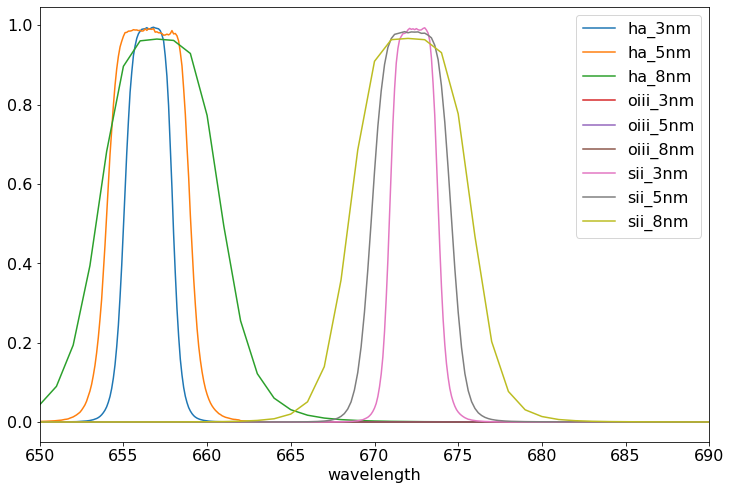

In [7]:
df_transmission = pd.concat(df_list)
df_transmission.plot()
plt.xlim(650, 690)

In [8]:
f_transmission = {}

for filter_name in filters:
    for bandpass in bandpasses:    
        key = f'{filter_name}_{bandpass}'
        df0 = df_transmission[key].dropna()
        f_transmission[key] = interpolate.interp1d(df0.index, df0.values)


In [9]:
# Specify index of refraction
n_index = 1.8

# Location of narrowband lines
ha_line = 656.28
oiii_line = 500.824
sii_line = 671.829


# Bandpass shift

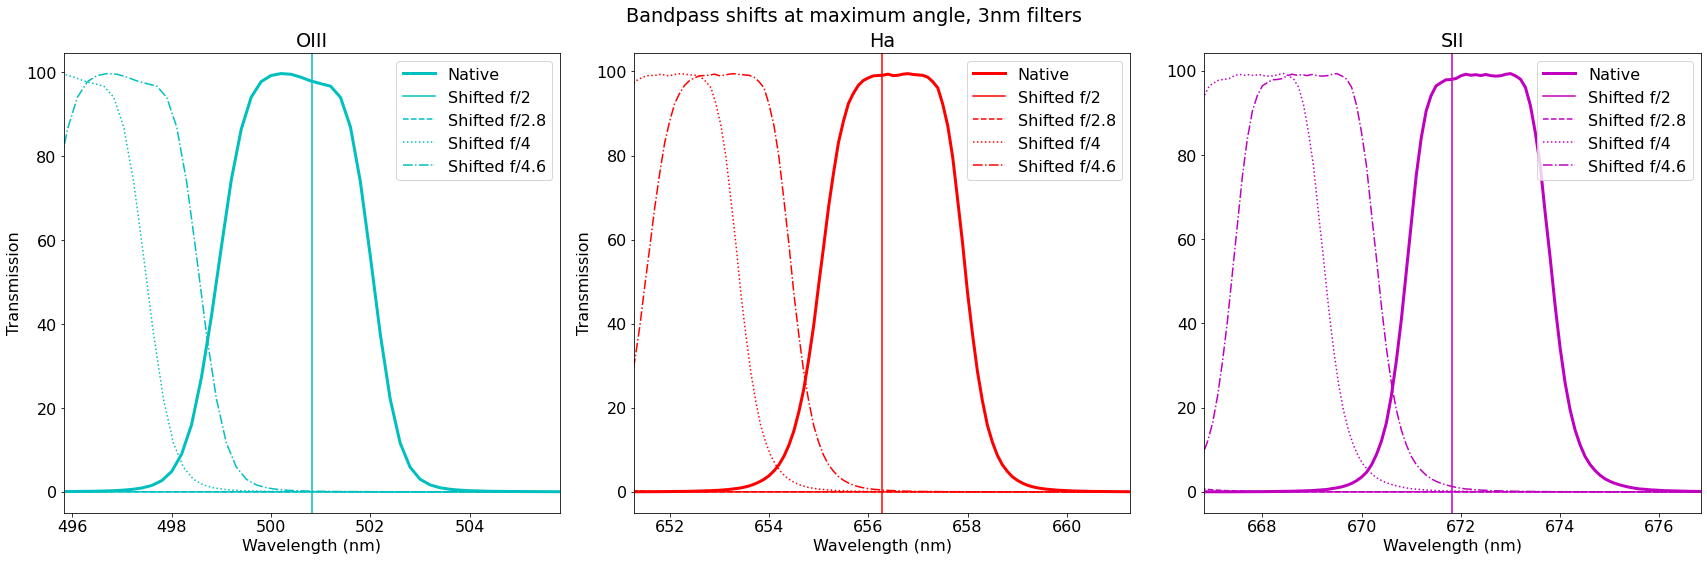

In [10]:
plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)

bandpass = '3nm'
focal_ratios = [2, 2.8, 4, 4.6]
linestyles = ['solid', 'dashed', 'dotted', 'dashdot']


filter_name = 'oiii'
key = f'{filter_name}_{bandpass}'
plt.plot(df_transmission.index, 100 * df_transmission[key], 'c', label='Native', lw=3)
for i, shift in enumerate(focal_ratios):
    fl = 1000
    aperture = fl / shift
    theta = get_theta(0, 0, aperture, 0, fl)
    plt.plot(df_transmission.index - wavelength_shift(oiii_line, theta, n_index), 100 * df_transmission[key], 'c', linestyle=linestyles[i], label=f'Shifted f/{shift}')
plt.legend()
plt.title('OIII')
plt.ylabel('Transmission')
plt.xlim(oiii_line - 5, oiii_line + 5)
plt.axvline(oiii_line, color='c')
plt.xlabel('Wavelength (nm)')

plt.subplot(1, 3, 2)
filter_name = 'ha'
key = f'{filter_name}_{bandpass}'
plt.plot(df_transmission.index, 100 * df_transmission[key], 'r', label='Native', lw=3)
for i, shift in enumerate(focal_ratios):
    fl = 1000
    aperture = fl / shift
    theta = get_theta(0, 0, aperture, 0, fl)
    plt.plot(df_transmission.index - wavelength_shift(oiii_line, theta, n_index), 100 * df_transmission[key], 'r', linestyle=linestyles[i], label=f'Shifted f/{shift}')
plt.legend()
plt.title('Ha')
plt.xlim(ha_line - 5, ha_line + 5)
plt.axvline(ha_line, color='r')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmission')


plt.subplot(1, 3, 3)
filter_name = 'sii'
key = f'{filter_name}_{bandpass}'
plt.plot(df_transmission.index, 100 * df_transmission[key], 'm', label='Native', lw=3)
for i, shift in enumerate(focal_ratios):
    fl = 1000
    aperture = fl / shift
    theta = get_theta(0, 0, aperture, 0, fl)
    plt.plot(df_transmission.index - wavelength_shift(oiii_line, theta, n_index), 100 * df_transmission[key], 'm', linestyle=linestyles[i], label=f'Shifted f/{shift}')
plt.xlabel('Wavelength (nm)')
plt.title('SII')
plt.legend()
plt.xlim(sii_line - 5, sii_line + 5)
plt.axvline(sii_line, color='m')
plt.suptitle('Bandpass shifts at maximum angle, 3nm filters')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('./figures/bandpass_shift.png')
plt.show()

/Volumes/Users/gshau/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/Volumes/Users/gshau/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/Volumes/Users/gshau/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning:

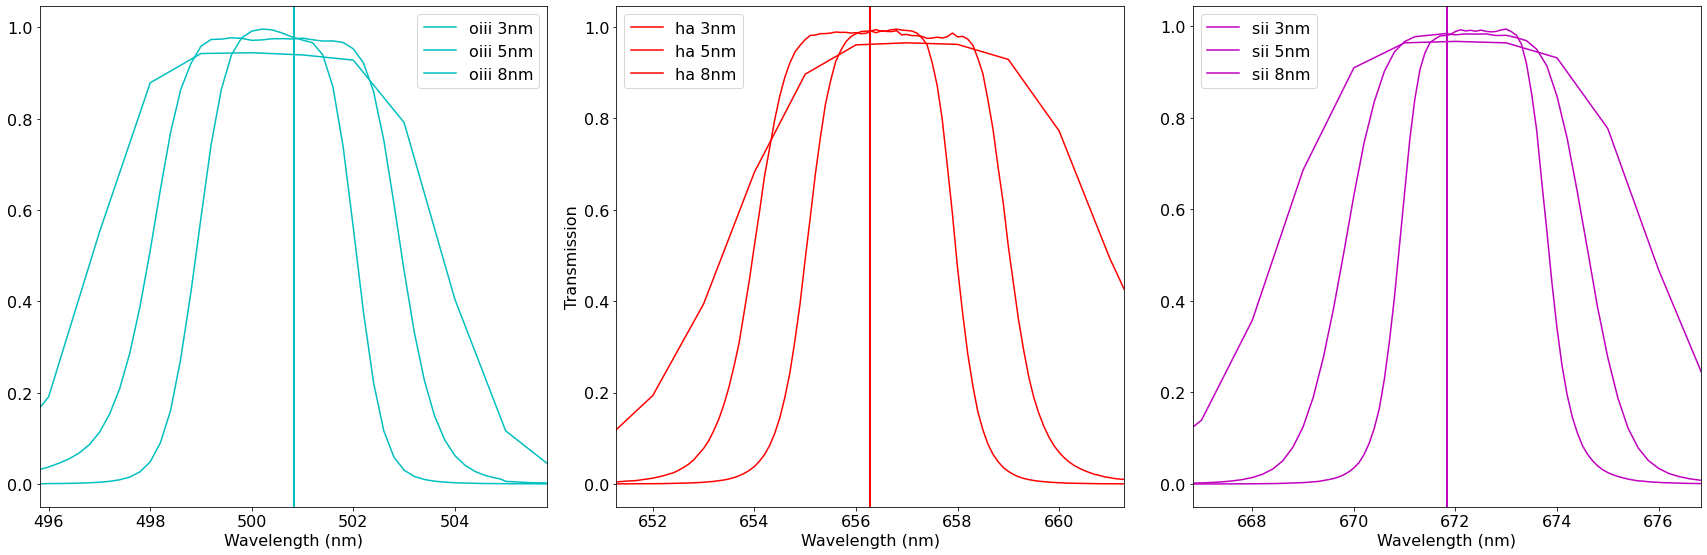

In [11]:
plt.figure(figsize=(24, 8))

for bandpass in bandpasses:
    plt.subplot(1, 3, 1)
    filter_name = 'oiii'
    key = f'{filter_name}_{bandpass}'
    plt.plot(df_transmission.index, df_transmission[key], 'c', label=f'{filter_name} {bandpass}')
    plt.legend()
    plt.xlim(oiii_line - 5, oiii_line + 5)
    plt.axvline(oiii_line, color='c')
    plt.xlabel('Wavelength (nm)')

    plt.subplot(1, 3, 2)
    filter_name = 'ha'
    key = f'{filter_name}_{bandpass}'
    plt.plot(df_transmission.index, df_transmission[key], 'r', label=f'{filter_name} {bandpass}')
    plt.legend()
    plt.xlim(ha_line - 5, ha_line + 5)
    plt.axvline(ha_line, color='r')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Transmission')


    plt.subplot(1, 3, 3)
    filter_name = 'sii'
    key = f'{filter_name}_{bandpass}'
    plt.plot(df_transmission.index, df_transmission[key], 'm', label=f'{filter_name} {bandpass}')
    plt.xlabel('Wavelength (nm)')
    plt.legend()
    plt.xlim(sii_line - 5, sii_line + 5)
    plt.axvline(sii_line, color='m')
    plt.tight_layout()
plt.savefig('./figures/bandpass_filters.png')
plt.show()

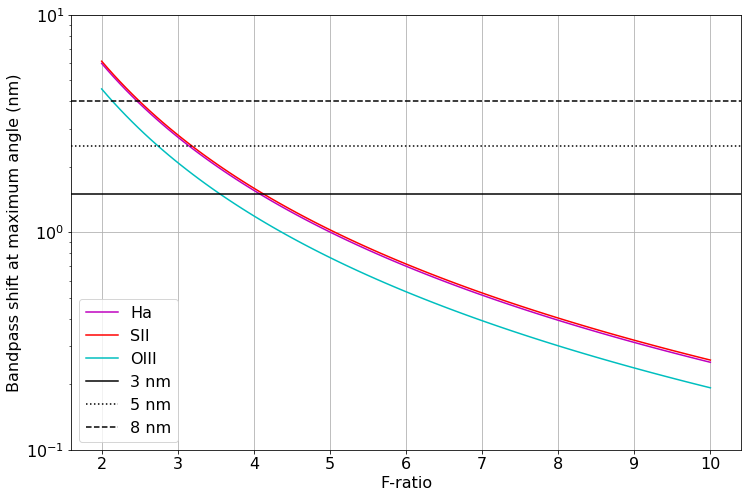

In [12]:
f_ratios = np.linspace(2, 10, 101)
thetas = get_theta(x=0, y=0, r=1/2, phi=0, fl=f_ratios)
plt.plot(f_ratios, wavelength_shift(ha_line, thetas, n_index), label='Ha', color='m')
plt.plot(f_ratios, wavelength_shift(sii_line, thetas, n_index), label='SII', color='r')
plt.plot(f_ratios, wavelength_shift(oiii_line, thetas, n_index), label='OIII', color='c')
plt.xlabel('F-ratio')
plt.yscale('log')
plt.ylim(.1, 10)
plt.axhline(1.5, color='k', linestyle='-', label='3 nm')
plt.axhline(2.5, color='k', linestyle=':', label='5 nm')
plt.axhline(4, color='k', linestyle='--', label='8 nm')
plt.ylabel('Bandpass shift at maximum angle (nm)')
plt.grid()
plt.legend()
plt.savefig('./figures/bandpass_shift_f_ratio.png')
plt.show()

# Effective Narrowband Transmission

In [13]:
fr = np.linspace(2.8, 20, 2000)

bands = {}
bands['ha'] = {'wavelength': ha_line}
bands['sii'] = {'wavelength': sii_line}
bands['oiii'] = {'wavelength': oiii_line}

In [14]:
color = {'ha': 'r', 'oiii': 'c', 'sii': 'm'}
styles = {'3nm': '-', '5nm': '--', '8nm': ':'}

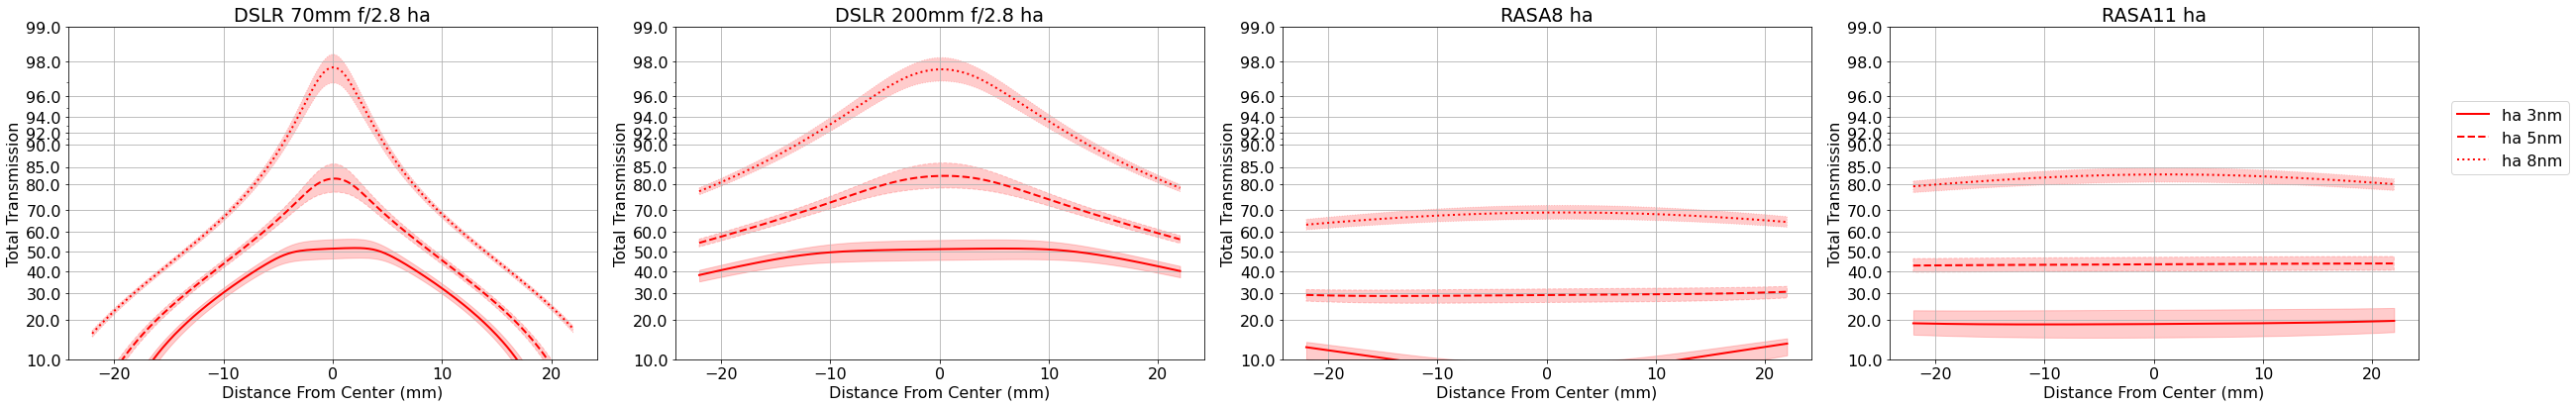

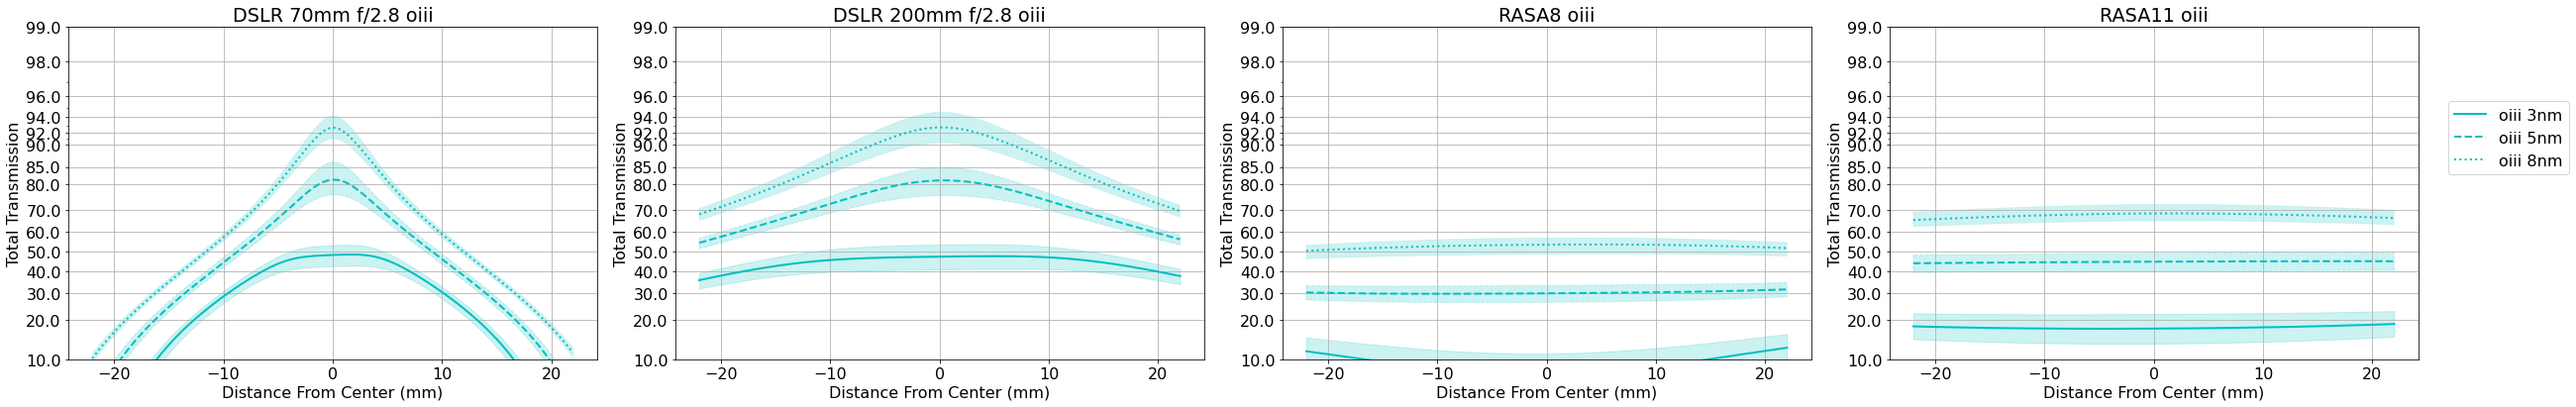

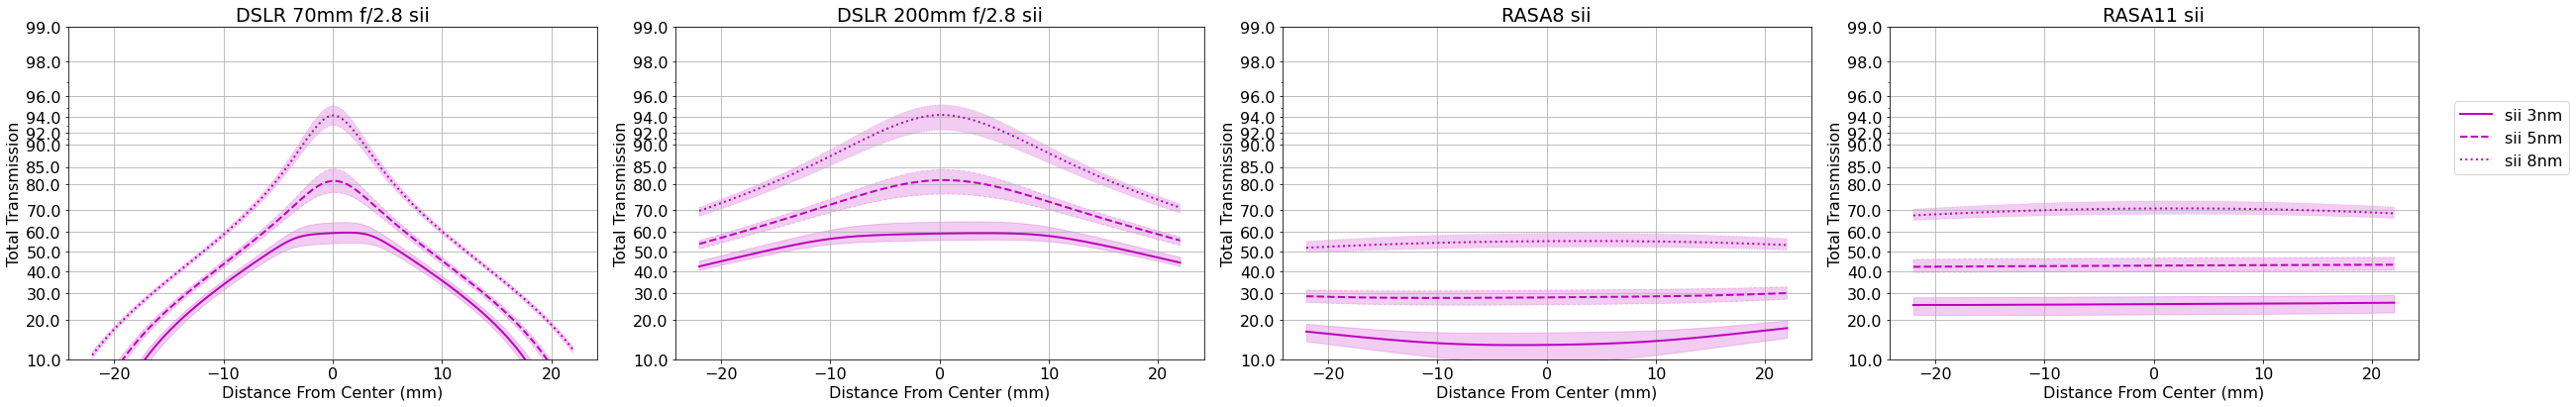

In [15]:
# RASA whitepaper: https://s3.amazonaws.com/celestron-site-support-files/support_files/rasa_white_paper_web.pdf
optics = {'DSLR 70mm f/2.8': {'aperture': 25,
                              'f_ratio': 2.8,
                              'r_min': 0},          
          'DSLR 200mm f/2.8': {'aperture': 72,
                               'f_ratio': 2.8,
                               'r_min': 0},                    
          'RASA8': {'aperture': 200,
                    'f_ratio': 2,
                    'r_min': 93/2},
          'RASA11': {'aperture': 280,
                     'f_ratio': 2.2,
                     'r_min': 114/2},          
         }

filter_names = ['ha', 'oiii', 'sii']
bandpasses = ['3nm', '5nm', '8nm']

show_diagonal_transmission(optics, filter_names, bandpasses, line_offset=0.1)


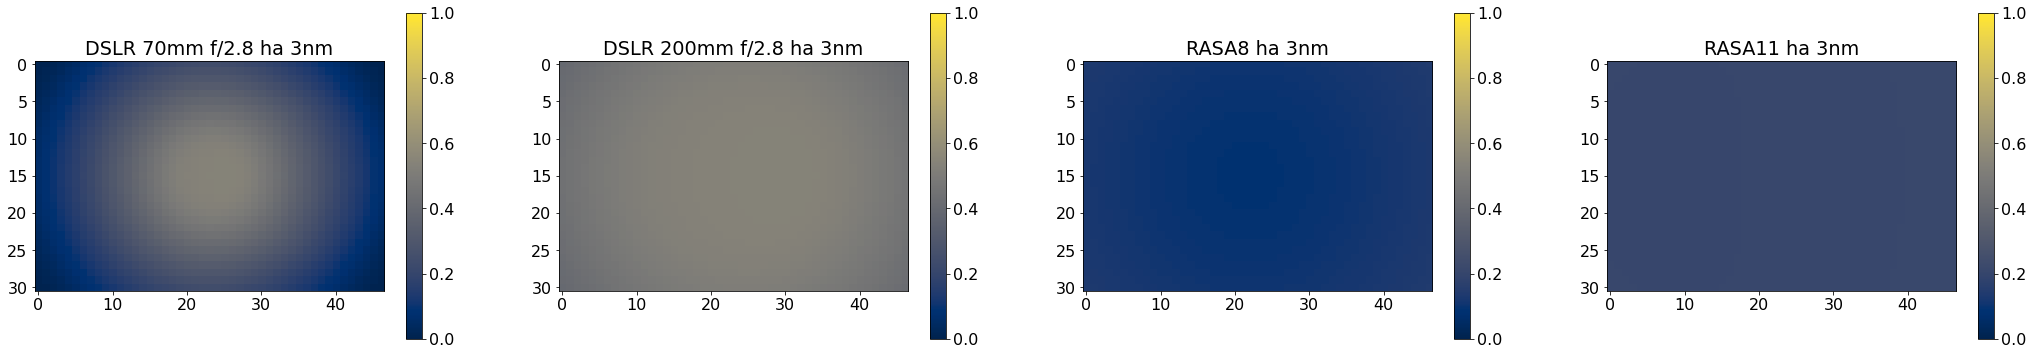

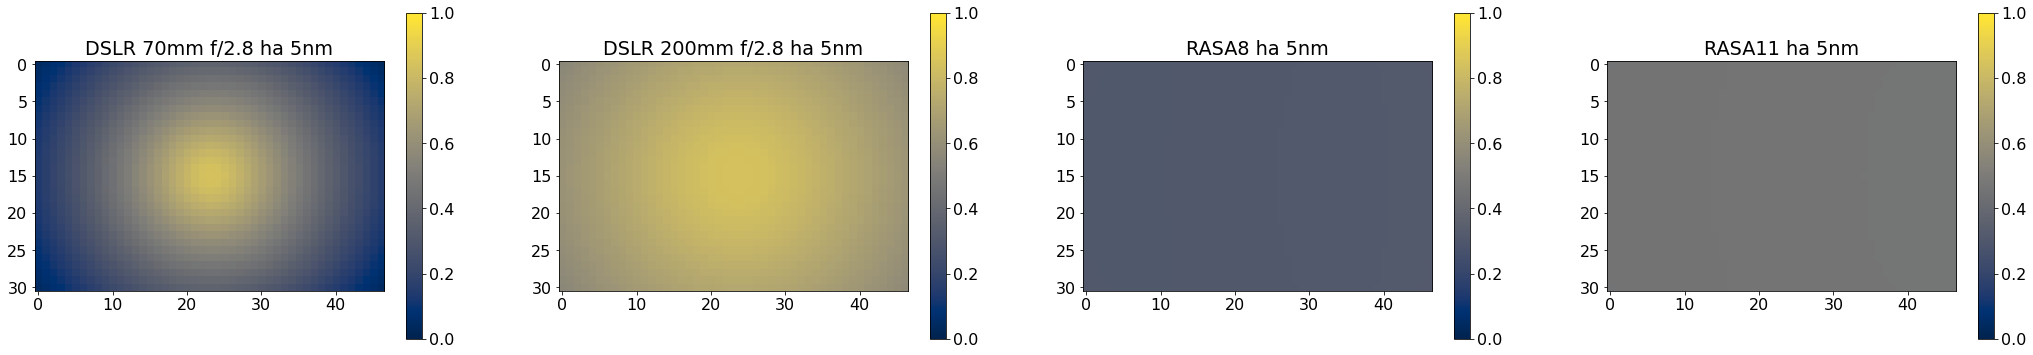

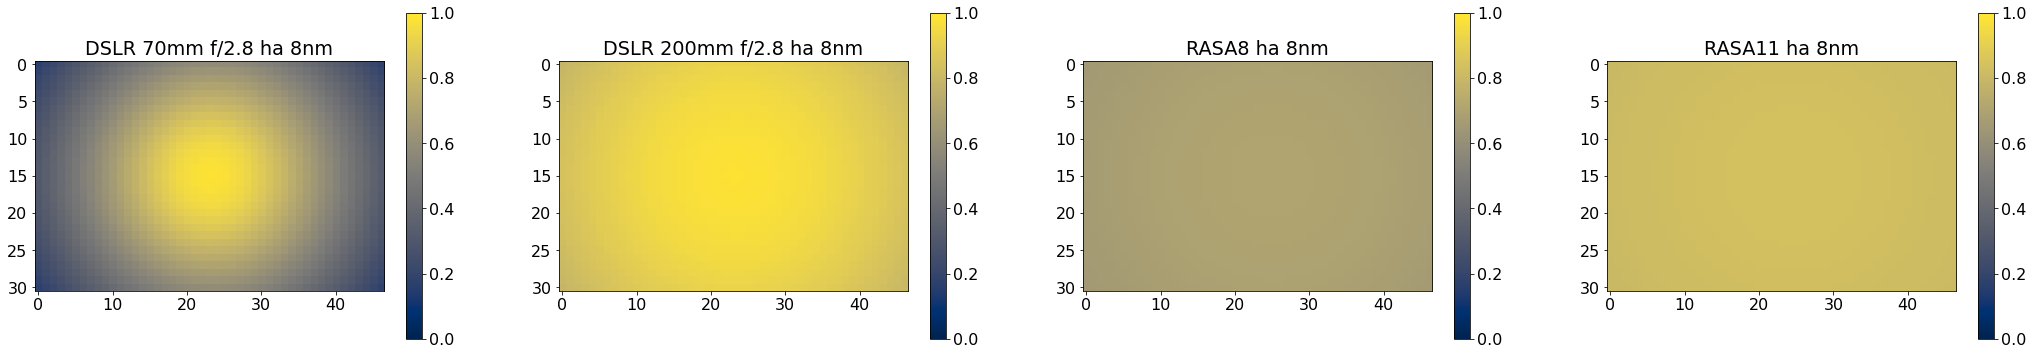

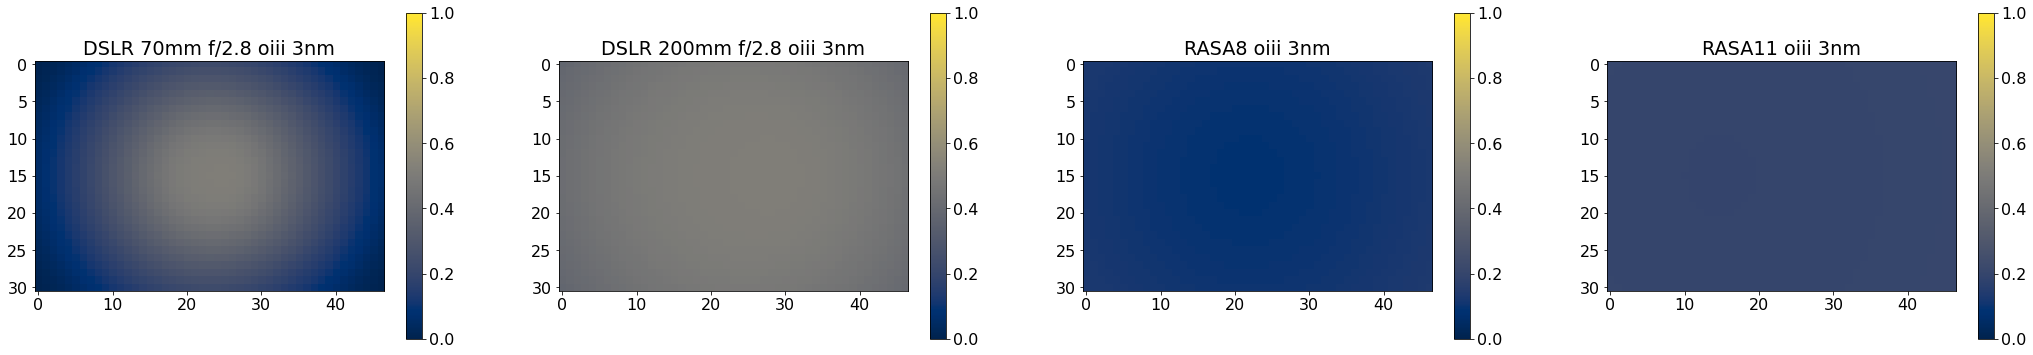

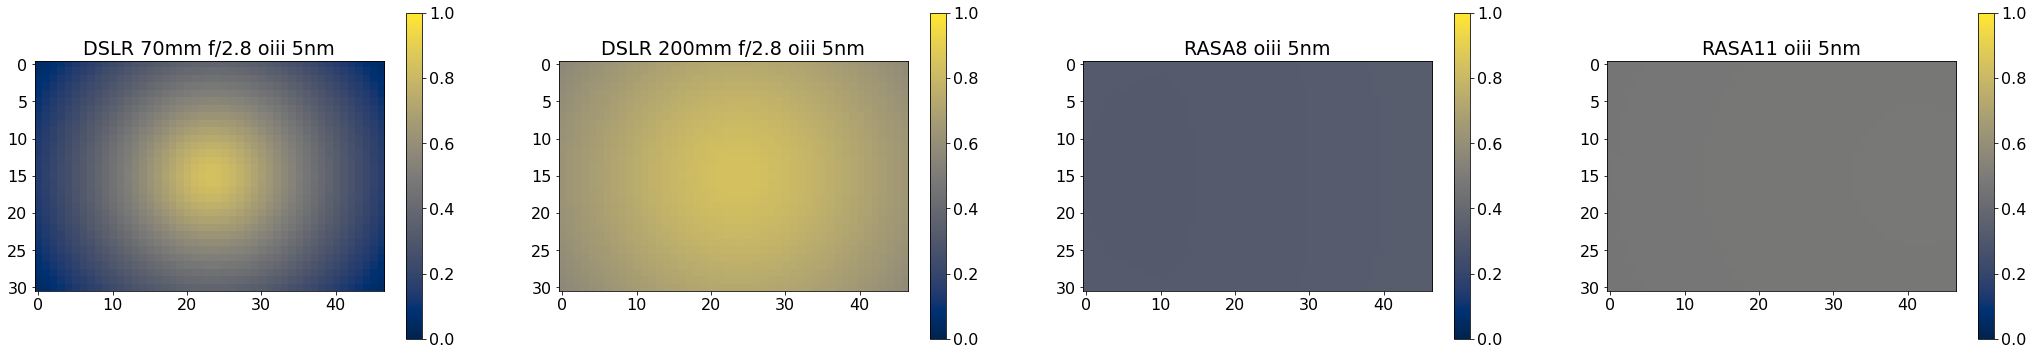

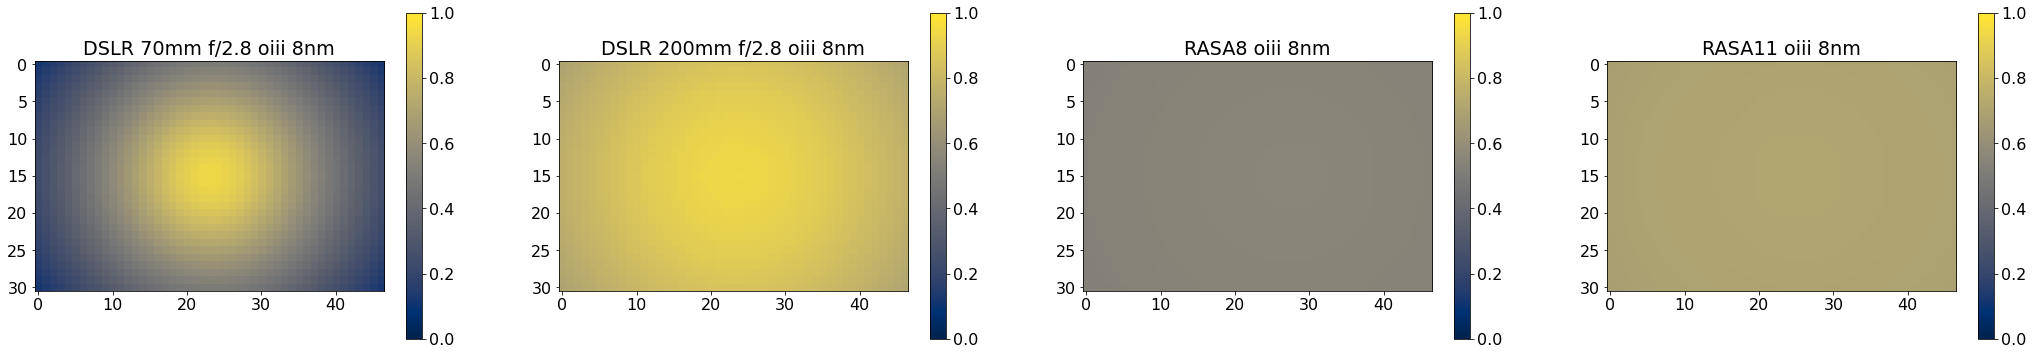

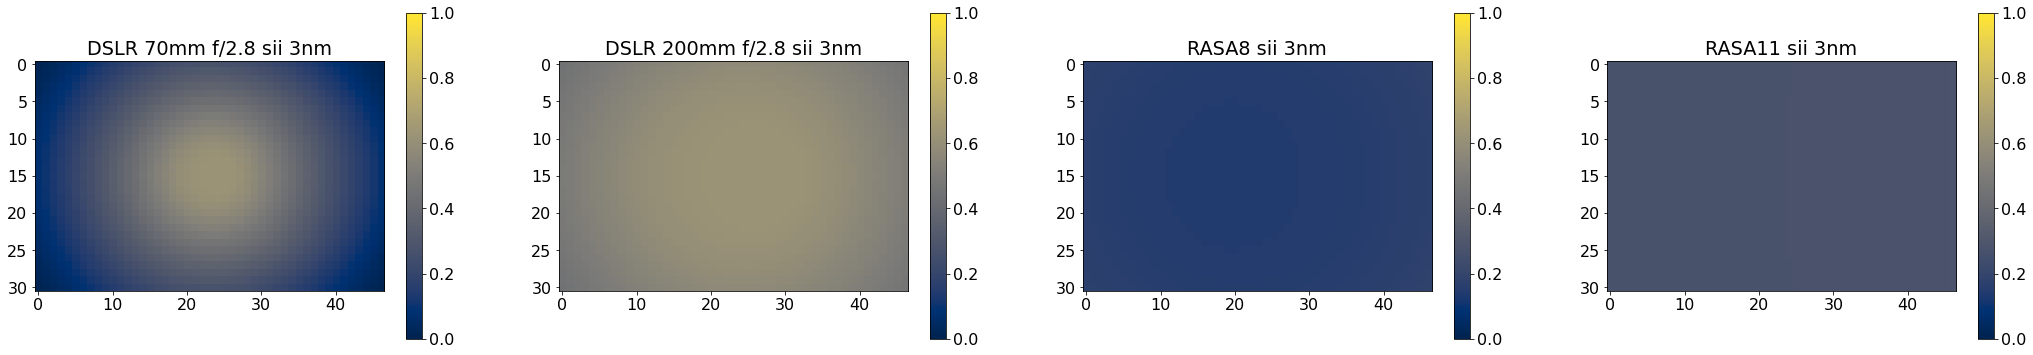

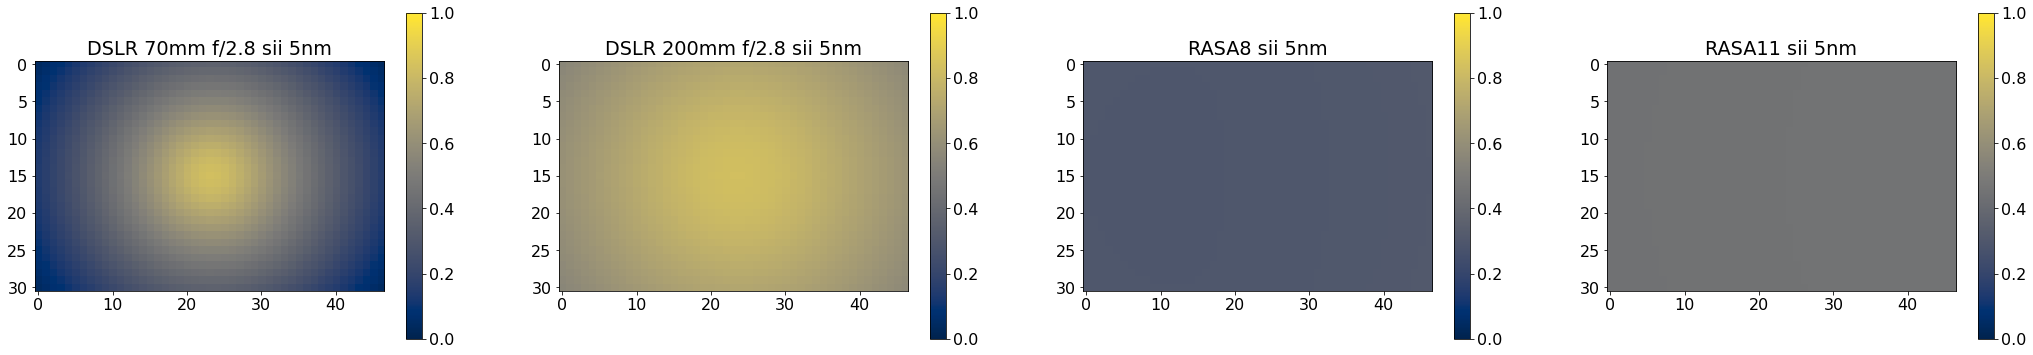

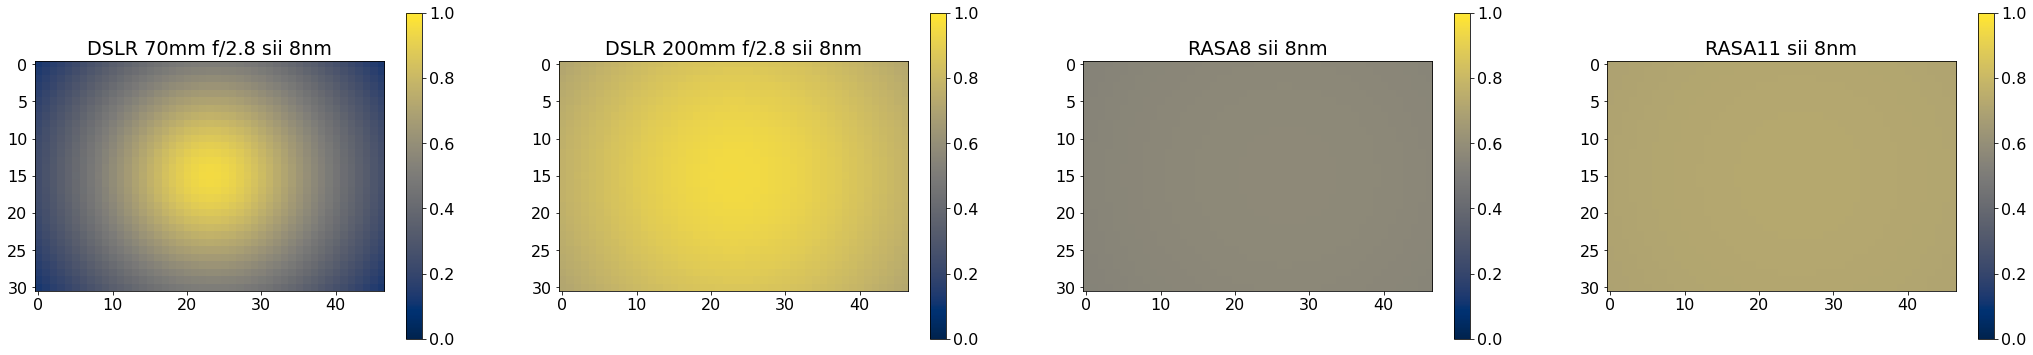

In [16]:
thetas = show_chip_view(optics, filter_names, bandpasses)

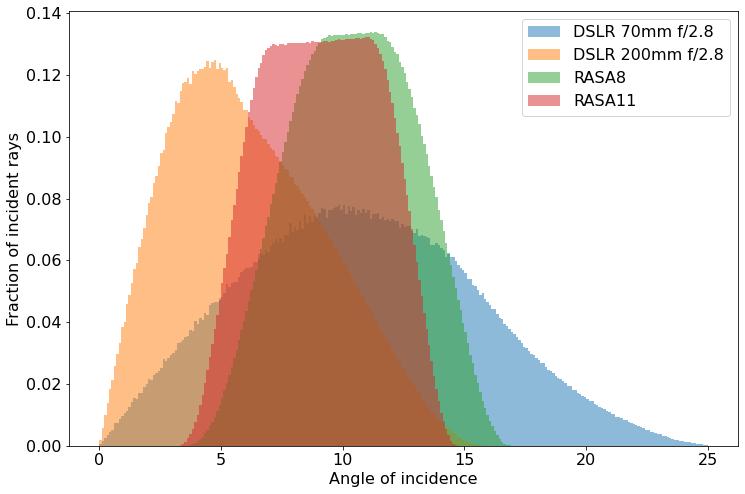

In [17]:
show_angle_distribution(thetas)

## With vs. without central obstruction

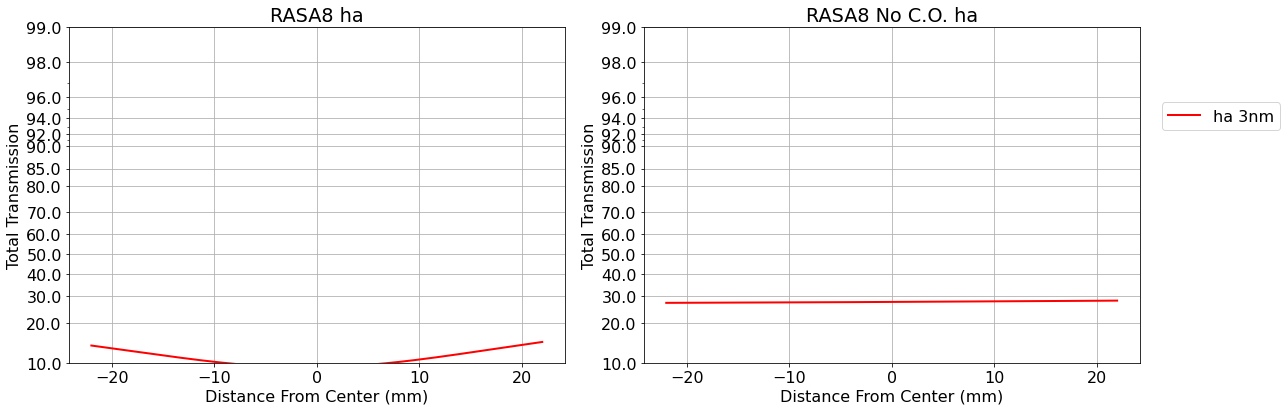

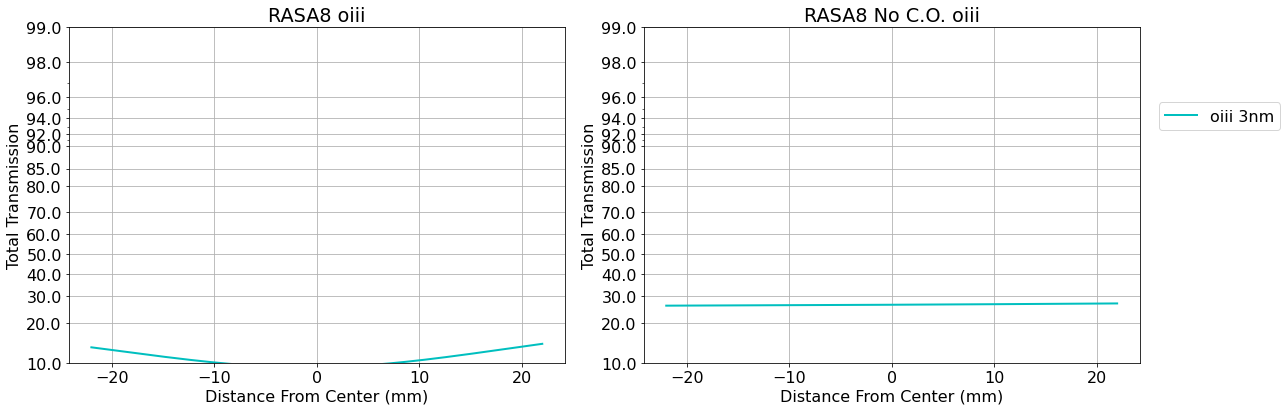

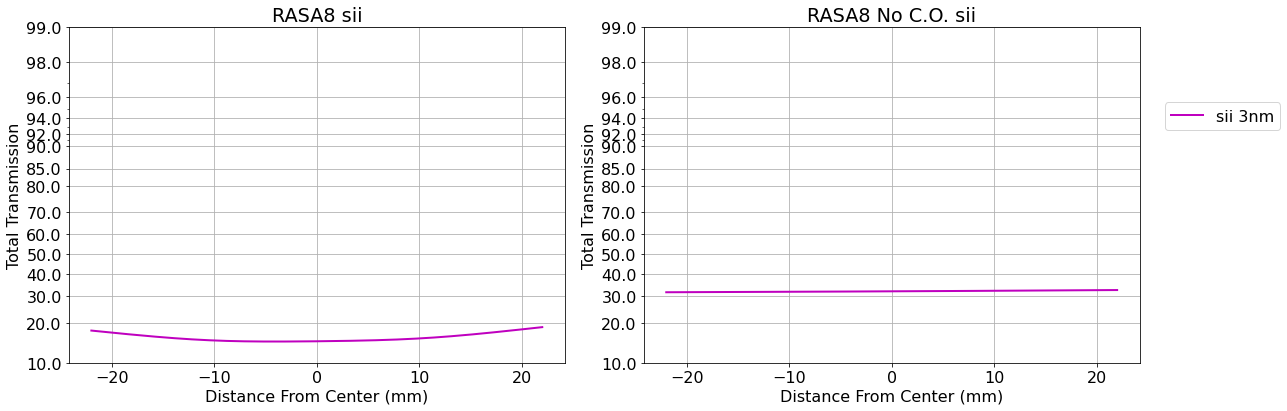

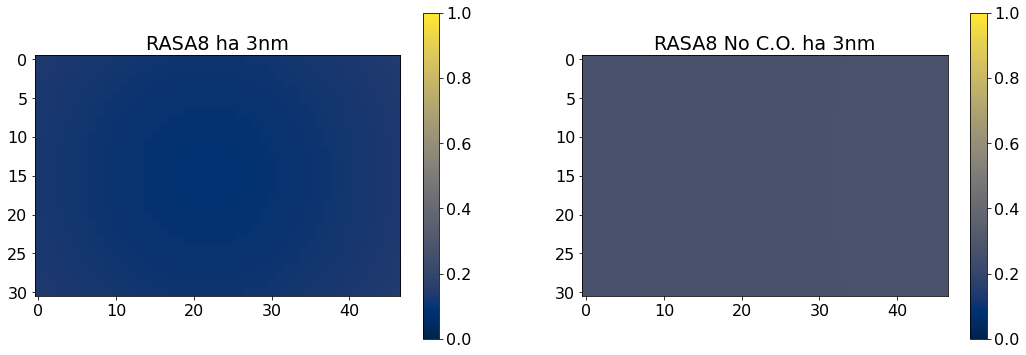

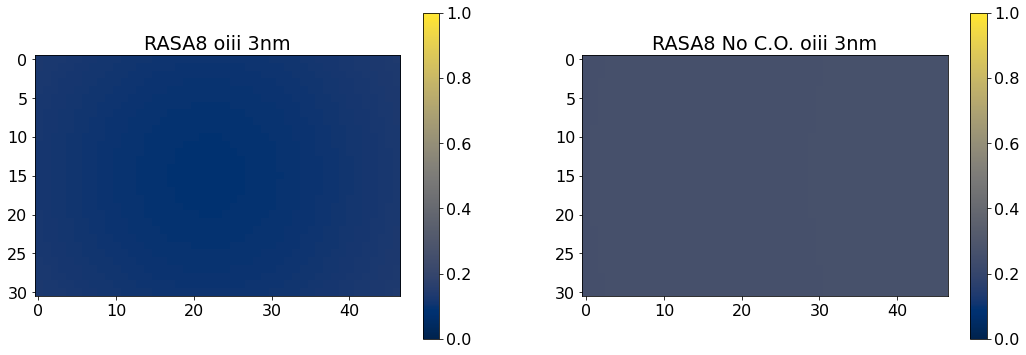

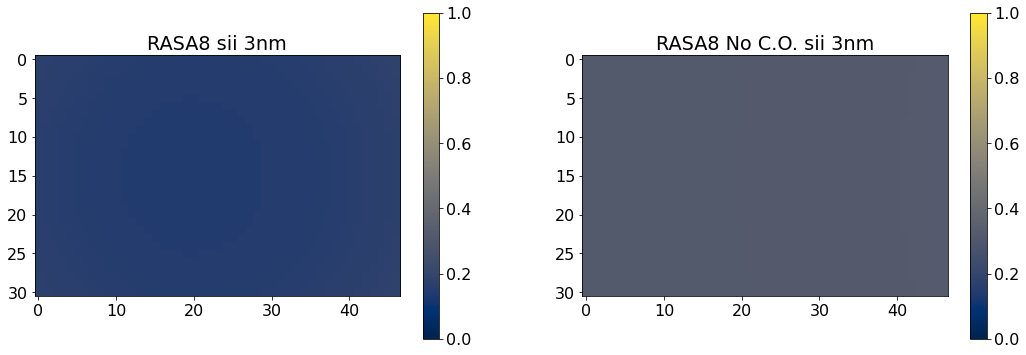

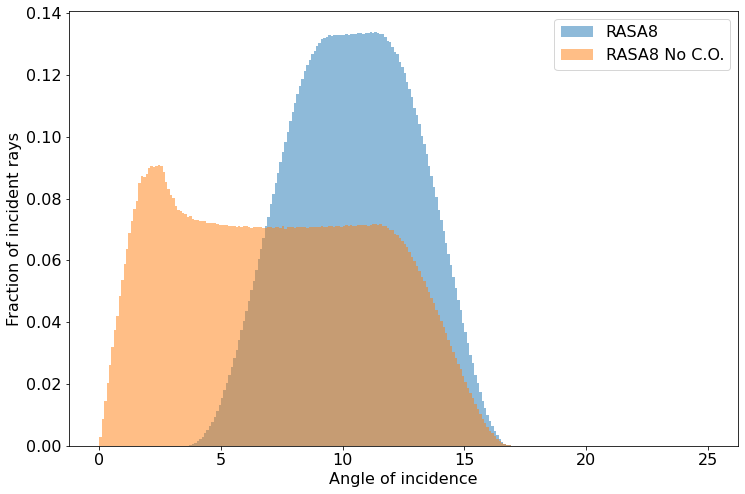

In [18]:

optics = {'RASA8': {'aperture': 200,
                    'f_ratio': 2,
                    'r_min': 93/2},
          'RASA8 No C.O.': {'aperture': 200,
                    'f_ratio': 2,
                    'r_min': 0},
          
         }

filter_names = ['ha', 'oiii', 'sii']
bandpasses = ['3nm']

show_diagonal_transmission(optics, filter_names, bandpasses, suffix='_central_obstruction')
thetas = show_chip_view(optics, filter_names, bandpasses, suffix='_central_obstruction')
show_angle_distribution(thetas, suffix='_central_obstruction')